In [1]:
from sys import path
import os
dir_actual = os.getcwd()
path.insert(0, 'C:/Users/guill/OneDrive/Documentos/Tesis/Proyect')

import pandas as pd
import numpy as np
import plotly.express as px
import myfuncions.tools_f as tools
import myfuncions.graphs_f as gf
from myfuncions.lammpin_f import wlammpin
import subprocess as sbp
import PDF.runner as pdf

In [2]:
name = 'M0-polrad_1.xyz'
atpos, eleList = tools.leer_xyz(name)
wlammpin(atpos,eleList,name)

M0-polrad_1.ini


In [3]:
tf = 400
from time import sleep

input = f"""
# 2NN EAM potential in LAMMPS

 units		metal
 atom_style	atomic
 boundary	f f f

 read_data	{name[:-4]}.ini
 pair_style	meam
 pair_coeff	* * ..\\..\\LAMMPS\\library-PtPdCo.meam Pt Pd Co ..\\..\\LAMMPS\\PtPdCo.pot Pt Pd Co
 
 neighbor	0.5 bin
 neigh_modify	every 1 delay 0 check yes once no
 velocity	all create 0.00 13478 rot yes mom yes dist gaussian
 timestep	0.005

 fix            1 all nve
 fix            2 all temp/rescale 10 0.00 0.00 1.0 1
 thermo         100
 thermo_style   custom step temp atoms pe ke etotal
 thermo_modify  lost ignore
 run 600

 unfix 2
 fix         3 all temp/berendsen 0.0 {tf} 0.1
 thermo		100
 run		3000

 unfix 3
 timestep   0.001
 thermo		100
 fix		4 all langevin {tf} {tf} 0.5 87654
 dump       4 all xyz 1 dump_temp.xyz
 undump     4
 run        1
 dump       4 all xyz 599 {name[:-4]}_d.xyz
 run		599
"""
with open('input.in','w') as archivo:
    archivo.write(input)


os.system('start powershell -Command lmp -in input.in; Start-Sleep -s 20; exit')
sleep(180)
#os.system('start powershell -Command lmp -in input.in')

Cambia etiquetas a "atpos"
jala


C:\Users/guill/OneDrive/Documentos/Tesis/Proyect\myfuncions\graphs_f.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


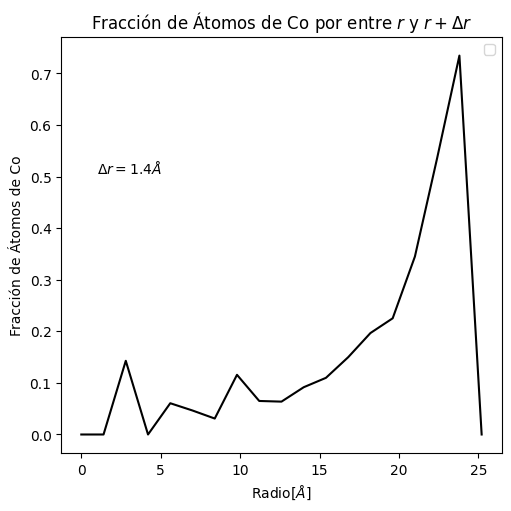

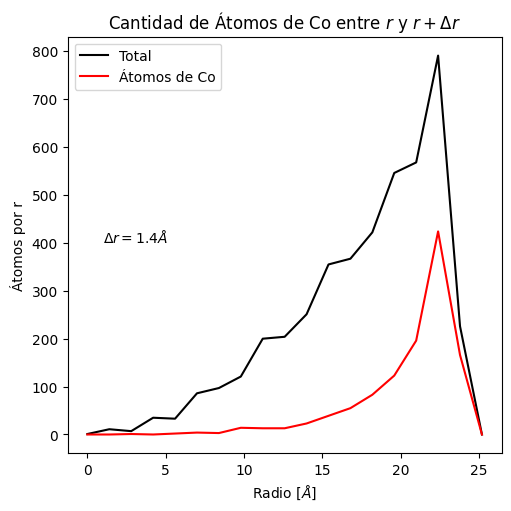

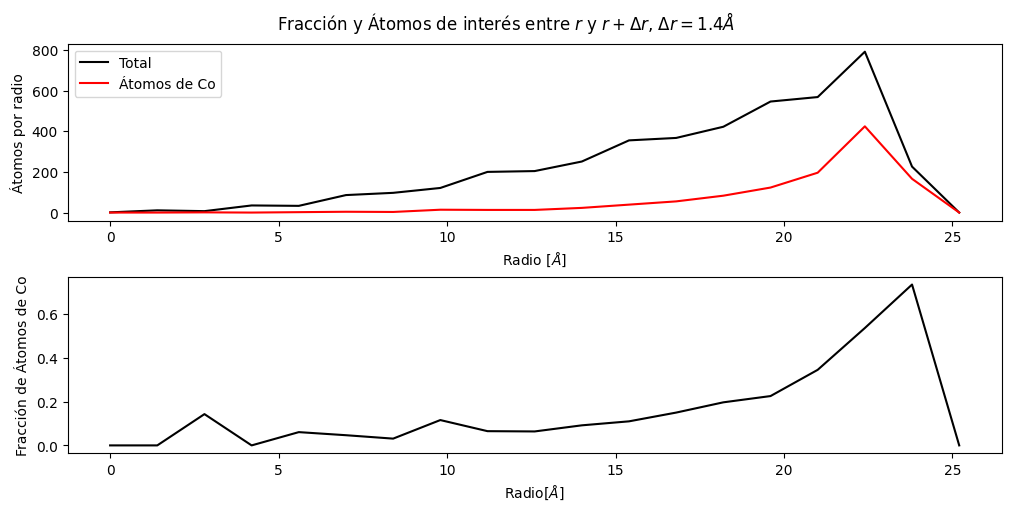

In [5]:
datpos, deleList = tools.leer_xyz(f'{name[:-4]}_d.xyz')
datpos, deleList = tools.cambiar_etiquetas_xyz(datpos, deleList, {1: 'Pt', 2: 'Pd', 3:'Co'})

gf.dump_graficar_fracc_atpr(datpos,'Co',1.4)
gf.dump_graficar_atpr(datpos,'Co',1.4)
gf.plot_dump_f_y_atpr(datpos,'Co',1.4)

In [6]:
tools.wXYZ(datpos,f'{name[:-4]}_d.xyz')
sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', f'{name[:-4]}_d.xyz'])

CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'M0-polrad_1_d.xyz'], returncode=0)

In [7]:
pdf.run_pdf(f'{name[:-4]}_d.xyz', dir_actual, 2600,0.02)

c:\Users\guill\OneDrive\Documentos\Tesis\Proyect\17_de_mayo\p1

  -1.19000003E-02  -7.92227983      -22.9188995              27   214985.000    
  -3.92773008      -4.06540012      -22.9559994              27   214985.000    
   2.01500002E-02  -4.07891989      -23.0170994              27   214985.000    
        4321  atomos      9333360  pares 
 Rango de distancias    2.14348459     -   49.1065903    
 Distancias promedio    25.1837425    
 Factor de normalizacion    454810.531    



In [15]:
exp = pd.DataFrame()

df_exp = pd.read_csv('C:/Users/guill/OneDrive/Documentos/Tesis/Proyect/26_de_abril/Post-PtPdCo-PDF.csv', sep = '\s+', header=None, names=['r','G(r)'])
df_exp = df_exp.replace('--',np.nan).dropna()
rest_df_exp = df_exp["G(r)"].iloc[1::2].astype(float)
rest_df_exp = rest_df_exp.reset_index(drop=True)
rest_df_exp.index *= 0.02

exp['exp'] = rest_df_exp

dx = 0.02

<>:3: SyntaxWarning:

invalid escape sequence '\s'

<>:3: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\guill\AppData\Local\Temp\ipykernel_29992\1804324009.py:3: SyntaxWarning:

invalid escape sequence '\s'



In [20]:
M1 = pd.read_csv('M0-polrad_1_d.txt', sep='\s+')
M = pd.DataFrame()
#M.index = M0['#r(A)']

M['M1'] = M1['G(r)']

ScaleX= 1.0
#M.index *= dx*ScaleX
M.index = (M.index + 1)*dx*ScaleX

for i in [1]:
    a = M[M[f'M{i}']== max(M[f'M{i}'])].index[0]
    b = 0.30 #### Al parecer este es el originario de todo lo que yo estaba haciendo
    c = b/(float(M[f'M{i}'][a]))
    M[f'M{i}'] *= c



<>:1: SyntaxWarning:

invalid escape sequence '\s'

<>:1: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\guill\AppData\Local\Temp\ipykernel_29992\4115411209.py:1: SyntaxWarning:

invalid escape sequence '\s'



In [21]:
F = pd.DataFrame()
exp = exp.astype(float)
M.astype(float)
F = M.join(exp, how='outer')

for i in [1]:
    F[f'M{i}'].loc[0] = 0

F = F.interpolate(method='quadratic')
#F['M0'] = F['M0'].interpolate(method='zero')
#F = F.fillna(method='ffill') 
#F = F.fillna(0)

for i in [1]:
    rest = F['exp'] - F[f'M{i}']
    error1 = np.sum(rest.loc[:44]**2)
    error_p1 = np.sqrt(error1/4321)
    #error2 = np.sum(rest.loc[44:]**2)
    #error_p2 = np.sqrt(error2/4321)
    #print(f'Para M{i} el error 1er es {error1}, el segundo es {error2}, y el error porcentual es {error_p1} y {error_p2}')
    print(f'Para M{i} el error es {error1}, y ECM {error_p1}')

#print(F.to_string())

fig = px.line(F, template='simple_white', title='Pair Distribution Functions of 9 Models',
    width=1000, height=500)
fig.update_layout(
    font_family="serif",
    title_font_family="serif")
fig.update_xaxes(title_text='G(r)')
fig.update_yaxes(title_text='r [A]')
fig.show()

Para M1 el error es 0.37739059656723056, y ECM 0.009345518556770342


C:\Users\guill\AppData\Local\Temp\ipykernel_29992\944219810.py:7: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


